In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from rgf.sklearn import RGFClassifier

In [2]:
df_train = pd.read_csv("../data/train_woe.csv")
df_test = pd.read_csv("../data/test_woe.csv")
#df_train = pd.read_csv("../data/sparse/train_good.csv")
#df_test = pd.read_csv("../data/sparse/test_good.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 269)

In [3]:
df_train.columns[:43]

Index([u'NAME_INCOME_TYPE', u'EMERGENCYSTATE_MODE', u'OCCUPATION_TYPE',
       u'NAME_TYPE_SUITE', u'FONDKAPREMONT_MODE', u'FLAG_OWN_CAR',
       u'WEEKDAY_APPR_PROCESS_START', u'CODE_GENDER', u'FLAG_OWN_REALTY',
       u'NAME_FAMILY_STATUS', u'NAME_CONTRACT_TYPE', u'NAME_HOUSING_TYPE',
       u'NAME_EDUCATION_TYPE', u'WALLSMATERIAL_MODE', u'HOUSETYPE_MODE',
       u'ORGANIZATION_TYPE', u'LAST(prev.NAME_YIELD_GROUP)',
       u'LAST(prev.FLAG_LAST_APPL_PER_CONTRACT)',
       u'LAST(pos.NAME_CONTRACT_STATUS)', u'LAST(prev.CODE_REJECT_REASON)',
       u'LAST(prev.NAME_PRODUCT_TYPE)', u'LAST(prev.NAME_CLIENT_TYPE)',
       u'LAST(prev.NAME_PORTFOLIO)', u'LAST(prev.NAME_CASH_LOAN_PURPOSE)',
       u'LAST(prev.WEEKDAY_APPR_PROCESS_START)',
       u'LAST(prev.NAME_CONTRACT_STATUS)', u'LAST(prev.NAME_GOODS_CATEGORY)',
       u'LAST(bureau.CREDIT_CURRENCY)', u'LAST(prev.NAME_SELLER_INDUSTRY)',
       u'LAST(bureau.CREDIT_ACTIVE)', u'LAST(prev.NAME_TYPE_SUITE)',
       u'LAST(card.NAME_CONTRACT_

In [4]:
test_ids.shape

(48744,)

In [5]:
df_train.columns = range( df_train.shape[1] )
df_test.columns = range( df_test.shape[1] )

In [6]:
df_test.loc[ : , 43:45].head()

,43,44,45
0,0.0000,2,0.752614
1,0.0000,2,0.564990
2,0.0000,2,0.000000
3,0.2626,2,0.525734
4,0.0000,2,0.202145


In [7]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

positive_data = None
negative_data = None


In [8]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.05
num_boost_round = 10000
ncat = 43
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1,  
          "reg_alpha" : 10 , 
          "reg_lambda": 10 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
}

In [9]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params_xgb = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
            "alpha": 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [10]:
NFOLDS = 5
ncat = 43
#X = features_train_t.values
X_test = df_test.values
X_train_full = df_train.values
# for xgb 
dtest = xgb.DMatrix( X_test )
dtrain_full = xgb.DMatrix( df_train.values )

labels_train = df_labels.values
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))

x_score = []
x_score_xgb = []

best_trees = []
fold_scores = []
N = 16

oof_train = []
oof_test = [] 

oof_train_xgb = []
oof_train_xgb = []

oof_train_full = []
oof_test_full = []
for s in range(N):
    
    
    params['seed'] = s
    x_train , x_val , y_train , y_val = train_test_split( df_train , df_labels , test_size = 0.3 , random_state=s)
    
    positive_indx = y_train[ y_train == 1 ]
    positive_data = x_train.loc[ positive_indx.index.values  ]

    negative_indx = y_train[ y_train == 0 ]
    negative_data = x_train.loc[  negative_indx.index.values  ]
    negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s*5 )

    print( positive_data.shape )
    print( negative_data.shape )

    labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

    x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
    x_train_sampled["y"] = labels
    x_train_sampled = x_train_sampled.sample(frac = 1 ,random_state = s )
    labels_sampled = x_train_sampled["y"].values
    
    x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 ).values
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf = kfold.split( x_train_sampled , labels_sampled  )
    best_trees = []
    fold_scores = []
    
    cv_train = np.zeros( len( labels_sampled ))
    cv_train_xgb = np.zeros( len(labels_sampled))
    
    #cv_eval_total = np.zeros( len( y_val ) )
    
    cv_pred = np.zeros( len( test_ids ) )
    cv_pred_xgb = np.zeros( len(test_ids))
    
    oof_train = np.zeros((  len( labels_train ) , ))
    oof_test = np.zeros((  len( test_ids )  , ))
    
    oof_train_xgb = np.zeros( (len(labels_train) , ) )
    oof_test_xgb = np.zeros( (len(test_ids) , ))
    
    oof_test_skf = np.empty((NFOLDS, len( test_ids )  ))
    oof_train_skf = np.empty((NFOLDS, len( labels_train )  ))
    
    oof_test_skf_xgb = np.empty((NFOLDS, len( test_ids )  ))
    oof_train_skf_xgb = np.empty((NFOLDS, len( labels_train )  ))
    
    
    cv_train_full = np.zeros( len( labels_train ))
    cv_train_full_xgb = np.zeros( len( labels_train ))
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = x_train_sampled[train_fold, :], x_train_sampled[validate, :], labels_sampled[train_fold], labels_sampled[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain  )
        
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 300 , early_stopping_rounds = 100 ) 
        cv_pred +=  bst.predict(  X_test , num_iteration = bst.best_iteration )
        
        cv_train[validate] += bst.predict( X_validate , num_iteration = bst.best_iteration )
        
        cv_train_full += bst.predict( X_train_full , num_iteration = bst.best_iteration )
        
        oof_train_skf[i, :] = bst.predict( X_train_full , num_iteration = bst.best_iteration  )
        oof_test_skf[ i , : ] = bst.predict( X_test , num_iteration = bst.best_iteration )
        
        
        
    cv_train_full /= NFOLDS
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=2*s)
    kf = kfold.split( x_train_sampled , labels_sampled  )
    
    params_xgb["seed"] = 2*s
    
    for i , (train_fold,validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = x_train_sampled[train_fold, :], x_train_sampled[validate, :], labels_sampled[train_fold], labels_sampled[validate]
        
        dtrain = xgb.DMatrix( X_train , label=label_train )
        dvalid = xgb.DMatrix( X_validate , label = label_validate )
        evallist = [ (dvalid, 'eval') ]
        bst = xgb.train(params_xgb, dtrain, num_boost_round, evallist  , early_stopping_rounds=100 , verbose_eval=300 )
        
        cv_pred_xgb = bst.predict( dtest , ntree_limit=bst.best_ntree_limit )
        cv_train_xgb[validate] += bst.predict( dvalid , ntree_limit=bst.best_ntree_limit  )
        
        oof_train_skf_xgb[ i , : ] = bst.predict( dtrain_full , ntree_limit=bst.best_ntree_limit )
        oof_test_skf_xgb[i , :] = bst.predict( dtest , ntree_limit=bst.best_ntree_limit )
        
        cv_train_full_xgb += bst.predict( dtrain_full , ntree_limit=bst.best_ntree_limit )
        
        
    cv_train_full_xgb /= NFOLDS  
    
    oof_test[:] = oof_test_skf.mean( axis = 0 )
    oof_train[:] = oof_train_skf.mean( axis = 0 )
    
    oof_test_xgb[:] = oof_test_skf_xgb.mean( axis = 0 )
    oof_train_xgb[:] = oof_train_skf_xgb.mean( axis = 0 )
    
    oof_train = oof_train.reshape(-1, 1)
    oof_test = oof_test.reshape( -1 , 1 )
    
    oof_train_xgb = oof_train_xgb.reshape( -1 , 1 )
    oof_test_xgb = oof_test_xgb.reshape( -1,1 )
    
    oof_train_full.append( oof_train ) 
    oof_train_full.append( oof_train_xgb )
    
    oof_test_full.append( oof_test )
    oof_test_full.append( oof_test_xgb )
    
    score_lgb = roc_auc_score( labels_train , cv_train_full / (s + 1.))
    score_xgb = roc_auc_score( labels_train , cv_train_full_xgb / (s + 1.))

    x_score.append( score_lgb )
    x_score_xgb.append( score_xgb )
    
    print( "current score in fold - lgb :", score_lgb , s+1)
    print( "current score in fold - xgb :", score_xgb , s+1)
    

    

(17485, 269)
(17368, 269)
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.634925	valid_0's auc: 0.733018
[600]	valid_0's binary_logloss: 0.610037	valid_0's auc: 0.75066
[900]	valid_0's binary_logloss: 0.597232	valid_0's auc: 0.75873
[1200]	valid_0's binary_logloss: 0.590155	valid_0's auc: 0.763217
[1500]	valid_0's binary_logloss: 0.584096	valid_0's auc: 0.767341
[1800]	valid_0's binary_logloss: 0.579959	valid_0's auc: 0.769964
[2100]	valid_0's binary_logloss: 0.577348	valid_0's auc: 0.771732
[2400]	valid_0's binary_logloss: 0.575203	valid_0's auc: 0.773085
[2700]	valid_0's binary_logloss: 0.573552	valid_0's auc: 0.774131
[3000]	valid_0's binary_logloss: 0.572471	valid_0's auc: 0.774885
[3300]	valid_0's binary_logloss: 0.571432	valid_0's auc: 0.77552
[3600]	valid_0's binary_logloss: 0.570618	valid_0's auc: 0.776053
[3900]	valid_0's binary_logloss: 0.569949	valid_0's auc: 0.776454
[4200]	valid_0's binary_logloss: 0.569494	valid_0's auc: 0.

[1500]	valid_0's binary_logloss: 0.593538	valid_0's auc: 0.752956
[1800]	valid_0's binary_logloss: 0.590965	valid_0's auc: 0.754882
[2100]	valid_0's binary_logloss: 0.588738	valid_0's auc: 0.756716
[2400]	valid_0's binary_logloss: 0.587275	valid_0's auc: 0.75788
[2700]	valid_0's binary_logloss: 0.586272	valid_0's auc: 0.758684
[3000]	valid_0's binary_logloss: 0.585481	valid_0's auc: 0.759348
[3300]	valid_0's binary_logloss: 0.584826	valid_0's auc: 0.759933
[3600]	valid_0's binary_logloss: 0.584281	valid_0's auc: 0.760398
[3900]	valid_0's binary_logloss: 0.583923	valid_0's auc: 0.760732
[4200]	valid_0's binary_logloss: 0.583611	valid_0's auc: 0.761068
[4500]	valid_0's binary_logloss: 0.583428	valid_0's auc: 0.761279
[4800]	valid_0's binary_logloss: 0.583217	valid_0's auc: 0.761491
[5100]	valid_0's binary_logloss: 0.583113	valid_0's auc: 0.761649
Early stopping, best iteration is:
[5110]	valid_0's binary_logloss: 0.583103	valid_0's auc: 0.761661
Training until validation scores don't imp

[2400]	valid_0's binary_logloss: 0.577886	valid_0's auc: 0.770837
[2700]	valid_0's binary_logloss: 0.576289	valid_0's auc: 0.771768
[3000]	valid_0's binary_logloss: 0.575314	valid_0's auc: 0.772338
[3300]	valid_0's binary_logloss: 0.574726	valid_0's auc: 0.772626
[3600]	valid_0's binary_logloss: 0.574064	valid_0's auc: 0.772965
[3900]	valid_0's binary_logloss: 0.573661	valid_0's auc: 0.773114
[4200]	valid_0's binary_logloss: 0.573219	valid_0's auc: 0.773364
[4500]	valid_0's binary_logloss: 0.572982	valid_0's auc: 0.773452
Early stopping, best iteration is:
[4402]	valid_0's binary_logloss: 0.573035	valid_0's auc: 0.77346
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.63649	valid_0's auc: 0.728676
[600]	valid_0's binary_logloss: 0.613823	valid_0's auc: 0.743168
[900]	valid_0's binary_logloss: 0.601506	valid_0's auc: 0.751031
[1200]	valid_0's binary_logloss: 0.594531	valid_0's auc: 0.755173
[1500]	valid_0's binary_logloss: 0.58996	valid_0'

[1800]	valid_0's binary_logloss: 0.588082	valid_0's auc: 0.758467
[2100]	valid_0's binary_logloss: 0.585981	valid_0's auc: 0.759941
[2400]	valid_0's binary_logloss: 0.584144	valid_0's auc: 0.761299
[2700]	valid_0's binary_logloss: 0.582694	valid_0's auc: 0.762383
[3000]	valid_0's binary_logloss: 0.581685	valid_0's auc: 0.763049
[3300]	valid_0's binary_logloss: 0.580905	valid_0's auc: 0.763627
Early stopping, best iteration is:
[3342]	valid_0's binary_logloss: 0.58079	valid_0's auc: 0.76373
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.634622	valid_0's auc: 0.734727
[600]	valid_0's binary_logloss: 0.612773	valid_0's auc: 0.747024
[900]	valid_0's binary_logloss: 0.600035	valid_0's auc: 0.754755
[1200]	valid_0's binary_logloss: 0.591805	valid_0's auc: 0.759681
[1500]	valid_0's binary_logloss: 0.587108	valid_0's auc: 0.761994
[1800]	valid_0's binary_logloss: 0.584152	valid_0's auc: 0.763316
[2100]	valid_0's binary_logloss: 0.582403	valid_0

[600]	valid_0's binary_logloss: 0.609217	valid_0's auc: 0.75186
[900]	valid_0's binary_logloss: 0.596063	valid_0's auc: 0.760059
[1200]	valid_0's binary_logloss: 0.588462	valid_0's auc: 0.765075
[1500]	valid_0's binary_logloss: 0.583647	valid_0's auc: 0.768371
[1800]	valid_0's binary_logloss: 0.579682	valid_0's auc: 0.770694
[2100]	valid_0's binary_logloss: 0.5768	valid_0's auc: 0.772398
[2400]	valid_0's binary_logloss: 0.574606	valid_0's auc: 0.773686
[2700]	valid_0's binary_logloss: 0.573008	valid_0's auc: 0.774634
[3000]	valid_0's binary_logloss: 0.57178	valid_0's auc: 0.775322
[3300]	valid_0's binary_logloss: 0.570892	valid_0's auc: 0.775873
[3600]	valid_0's binary_logloss: 0.57017	valid_0's auc: 0.776352
[3900]	valid_0's binary_logloss: 0.569564	valid_0's auc: 0.776668
[4200]	valid_0's binary_logloss: 0.569014	valid_0's auc: 0.776981
[4500]	valid_0's binary_logloss: 0.56863	valid_0's auc: 0.777192
Early stopping, best iteration is:
[4645]	valid_0's binary_logloss: 0.568405	valid_0

[600]	valid_0's binary_logloss: 0.61448	valid_0's auc: 0.739841
[900]	valid_0's binary_logloss: 0.601722	valid_0's auc: 0.749566
[1200]	valid_0's binary_logloss: 0.594487	valid_0's auc: 0.755278
[1500]	valid_0's binary_logloss: 0.588872	valid_0's auc: 0.759381
[1800]	valid_0's binary_logloss: 0.585079	valid_0's auc: 0.762504
[2100]	valid_0's binary_logloss: 0.582322	valid_0's auc: 0.764634
[2400]	valid_0's binary_logloss: 0.580285	valid_0's auc: 0.766246
[2700]	valid_0's binary_logloss: 0.578665	valid_0's auc: 0.767456
[3000]	valid_0's binary_logloss: 0.577343	valid_0's auc: 0.768553
[3300]	valid_0's binary_logloss: 0.576128	valid_0's auc: 0.76953
[3600]	valid_0's binary_logloss: 0.575263	valid_0's auc: 0.770202
[3900]	valid_0's binary_logloss: 0.574584	valid_0's auc: 0.770732
[4200]	valid_0's binary_logloss: 0.574125	valid_0's auc: 0.771129
[4500]	valid_0's binary_logloss: 0.57357	valid_0's auc: 0.771646
[4800]	valid_0's binary_logloss: 0.573161	valid_0's auc: 0.771981
[5100]	valid_0'

[300]	valid_0's binary_logloss: 0.636721	valid_0's auc: 0.726527
[600]	valid_0's binary_logloss: 0.614259	valid_0's auc: 0.740116
[900]	valid_0's binary_logloss: 0.603972	valid_0's auc: 0.746235
[1200]	valid_0's binary_logloss: 0.596807	valid_0's auc: 0.751071
[1500]	valid_0's binary_logloss: 0.591703	valid_0's auc: 0.754732
[1800]	valid_0's binary_logloss: 0.588628	valid_0's auc: 0.756971
[2100]	valid_0's binary_logloss: 0.586462	valid_0's auc: 0.758473
[2400]	valid_0's binary_logloss: 0.584778	valid_0's auc: 0.759711
[2700]	valid_0's binary_logloss: 0.583642	valid_0's auc: 0.760497
[3000]	valid_0's binary_logloss: 0.582931	valid_0's auc: 0.760964
[3300]	valid_0's binary_logloss: 0.582298	valid_0's auc: 0.761478
[3600]	valid_0's binary_logloss: 0.58179	valid_0's auc: 0.76184
[3900]	valid_0's binary_logloss: 0.581459	valid_0's auc: 0.762142
Early stopping, best iteration is:
[3880]	valid_0's binary_logloss: 0.581447	valid_0's auc: 0.762163
Training until validation scores don't improve

[3900]	valid_0's binary_logloss: 0.577132	valid_0's auc: 0.767792
[4200]	valid_0's binary_logloss: 0.576816	valid_0's auc: 0.768037
[4500]	valid_0's binary_logloss: 0.57657	valid_0's auc: 0.768256
Early stopping, best iteration is:
[4591]	valid_0's binary_logloss: 0.576522	valid_0's auc: 0.768295
[0]	eval-auc:0.641326
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.737159
[600]	eval-auc:0.749564
[900]	eval-auc:0.755917
[1200]	eval-auc:0.759229
[1500]	eval-auc:0.760936
Stopping. Best iteration:
[1439]	eval-auc:0.760937

[0]	eval-auc:0.644387
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.740439
[600]	eval-auc:0.754246
[900]	eval-auc:0.760508
[1200]	eval-auc:0.763747
[1500]	eval-auc:0.765873
Stopping. Best iteration:
[1581]	eval-auc:0.766411

[0]	eval-auc:0.642229
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.746752
[600]	eval-auc:0.759221
[900]	eval-auc:0.76523
[1200]	eval-auc:0.767954
[1500]	eval-auc:0.769

[3000]	valid_0's binary_logloss: 0.572923	valid_0's auc: 0.773573
[3300]	valid_0's binary_logloss: 0.571889	valid_0's auc: 0.774351
[3600]	valid_0's binary_logloss: 0.571021	valid_0's auc: 0.774947
[3900]	valid_0's binary_logloss: 0.570529	valid_0's auc: 0.775293
[4200]	valid_0's binary_logloss: 0.570075	valid_0's auc: 0.775548
[4500]	valid_0's binary_logloss: 0.569706	valid_0's auc: 0.775856
[4800]	valid_0's binary_logloss: 0.569446	valid_0's auc: 0.775966
[5100]	valid_0's binary_logloss: 0.56922	valid_0's auc: 0.776127
Early stopping, best iteration is:
[5152]	valid_0's binary_logloss: 0.569187	valid_0's auc: 0.776164
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.634141	valid_0's auc: 0.734588
[600]	valid_0's binary_logloss: 0.609882	valid_0's auc: 0.750091
[900]	valid_0's binary_logloss: 0.596671	valid_0's auc: 0.758723
[1200]	valid_0's binary_logloss: 0.588214	valid_0's auc: 0.764112
[1500]	valid_0's binary_logloss: 0.582817	valid_

[0]	eval-auc:0.683466
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.733817
[600]	eval-auc:0.747473
[900]	eval-auc:0.753995
[1200]	eval-auc:0.758516
[1500]	eval-auc:0.76172
Stopping. Best iteration:
[1520]	eval-auc:0.76188

[0]	eval-auc:0.688187
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.739802
[600]	eval-auc:0.753872
[900]	eval-auc:0.760249
[1200]	eval-auc:0.764345
[1500]	eval-auc:0.766535
Stopping. Best iteration:
[1438]	eval-auc:0.766538

[0]	eval-auc:0.689012
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.742806
[600]	eval-auc:0.755401
[900]	eval-auc:0.760922
[1200]	eval-auc:0.764419
[1500]	eval-auc:0.766949
Stopping. Best iteration:
[1613]	eval-auc:0.767724

[0]	eval-auc:0.688388
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.733291
[600]	eval-auc:0.746841
[900]	eval-auc:0.75351
[1200]	eval-auc:0.757392
[1500]	eval-auc:0.759554
Stopping. Best iteration:
[1473]	eval-auc:0

[300]	eval-auc:0.741554
[600]	eval-auc:0.754855
[900]	eval-auc:0.760659
[1200]	eval-auc:0.764076
[1500]	eval-auc:0.765829
Stopping. Best iteration:
[1432]	eval-auc:0.765829

[0]	eval-auc:0.686884
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.739839
[600]	eval-auc:0.752542
[900]	eval-auc:0.758129
[1200]	eval-auc:0.761329
[1500]	eval-auc:0.763045
Stopping. Best iteration:
[1508]	eval-auc:0.763091

[0]	eval-auc:0.688287
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.741634
[600]	eval-auc:0.754871
[900]	eval-auc:0.760555
[1200]	eval-auc:0.763836
[1500]	eval-auc:0.765554
Stopping. Best iteration:
[1421]	eval-auc:0.765554

('current score in fold - lgb :', 0.792357587780845, 13)
('current score in fold - xgb :', 0.7711743331925532, 13)
(17340, 269)
(17381, 269)
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.636438	valid_0's auc: 0.728325
[600]	valid_0's binary_logloss: 0.613585	valid_0's 

[2700]	valid_0's binary_logloss: 0.578621	valid_0's auc: 0.767323
[3000]	valid_0's binary_logloss: 0.577579	valid_0's auc: 0.768096
[3300]	valid_0's binary_logloss: 0.576707	valid_0's auc: 0.768794
[3600]	valid_0's binary_logloss: 0.576003	valid_0's auc: 0.769274
[3900]	valid_0's binary_logloss: 0.57542	valid_0's auc: 0.769737
[4200]	valid_0's binary_logloss: 0.574876	valid_0's auc: 0.770147
[4500]	valid_0's binary_logloss: 0.574459	valid_0's auc: 0.770452
[4800]	valid_0's binary_logloss: 0.574201	valid_0's auc: 0.770663
[5100]	valid_0's binary_logloss: 0.574021	valid_0's auc: 0.770769
[5400]	valid_0's binary_logloss: 0.573774	valid_0's auc: 0.770979
Early stopping, best iteration is:
[5444]	valid_0's binary_logloss: 0.573721	valid_0's auc: 0.771027
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.632379	valid_0's auc: 0.741209
[600]	valid_0's binary_logloss: 0.606354	valid_0's auc: 0.758055
[900]	valid_0's binary_logloss: 0.593747	valid_

[600]	valid_0's binary_logloss: 0.61008	valid_0's auc: 0.747293
[900]	valid_0's binary_logloss: 0.597745	valid_0's auc: 0.755155
[1200]	valid_0's binary_logloss: 0.589295	valid_0's auc: 0.761297
[1500]	valid_0's binary_logloss: 0.584157	valid_0's auc: 0.764697
[1800]	valid_0's binary_logloss: 0.580677	valid_0's auc: 0.766908
[2100]	valid_0's binary_logloss: 0.577992	valid_0's auc: 0.768793
[2400]	valid_0's binary_logloss: 0.5762	valid_0's auc: 0.770109
[2700]	valid_0's binary_logloss: 0.574759	valid_0's auc: 0.771019
[3000]	valid_0's binary_logloss: 0.573667	valid_0's auc: 0.771717
[3300]	valid_0's binary_logloss: 0.572902	valid_0's auc: 0.772263
[3600]	valid_0's binary_logloss: 0.572264	valid_0's auc: 0.772671
[3900]	valid_0's binary_logloss: 0.571919	valid_0's auc: 0.772841
Early stopping, best iteration is:
[4027]	valid_0's binary_logloss: 0.571732	valid_0's auc: 0.772976
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.633001	valid_0'

In [14]:
new_train = np.hstack( oof_train_full )
new_test = np.hstack( oof_test_full )

In [15]:
print( "SUCCES")

SUCCES


In [16]:
new_test.shape

(48744, 32)

In [17]:
learning_rate = 0.01
num_leaves = 16
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "dart",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.01,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
          "reg_alpha" : 20 , 
          "reg_lambda": 20 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
          
}

# Lightgbm model with oof_preds

In [18]:
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( test_ids ))

NFOLDS = 5 

M = 16 
x_score = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))
    
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.379057	valid_0's auc: 0.783345
[200]	valid_0's binary_logloss: 0.30656	valid_0's auc: 0.789976
[300]	valid_0's binary_logloss: 0.282494	valid_0's auc: 0.790717
[400]	valid_0's binary_logloss: 0.267422	valid_0's auc: 0.791098
[500]	valid_0's binary_logloss: 0.255306	valid_0's auc: 0.791462
[600]	valid_0's binary_logloss: 0.251526	valid_0's auc: 0.791692
[700]	valid_0's binary_logloss: 0.244771	valid_0's auc: 0.792198
[800]	valid_0's binary_logloss: 0.242743	valid_0's auc: 0.792368
[900]	valid_0's binary_logloss: 0.240235	valid_0's auc: 0.792598
[1000]	valid_0's binary_logloss: 0.238715	valid_0's auc: 0.792778
[1100]	valid_0's binary_logloss: 0.2384	valid_0's auc: 0.792895
[1200]	valid_0's binary_logloss: 0.238085	valid_0's auc: 0.793001
[1300]	valid_0's binary_logloss: 0.238107	valid_0's auc: 0.793072
Early stopping, best iteration is:
[1220]	valid_0's binary_logloss: 0.237891	valid_0's auc:

[400]	valid_0's binary_logloss: 0.25978	valid_0's auc: 0.794412
[500]	valid_0's binary_logloss: 0.252442	valid_0's auc: 0.794713
[600]	valid_0's binary_logloss: 0.249139	valid_0's auc: 0.794976
[700]	valid_0's binary_logloss: 0.246381	valid_0's auc: 0.79509
[800]	valid_0's binary_logloss: 0.244013	valid_0's auc: 0.795319
[900]	valid_0's binary_logloss: 0.241648	valid_0's auc: 0.795445
[1000]	valid_0's binary_logloss: 0.241094	valid_0's auc: 0.795568
[1100]	valid_0's binary_logloss: 0.239679	valid_0's auc: 0.795637
[1200]	valid_0's binary_logloss: 0.238689	valid_0's auc: 0.79577
Early stopping, best iteration is:
[1197]	valid_0's binary_logloss: 0.238556	valid_0's auc: 0.795769
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.376612	valid_0's auc: 0.790044
[200]	valid_0's binary_logloss: 0.301798	valid_0's auc: 0.792493
[300]	valid_0's binary_logloss: 0.271419	valid_0's auc: 0.793206
[400]	valid_0's binary_logloss: 0.259837	valid_0's auc: 

[900]	valid_0's binary_logloss: 0.242928	valid_0's auc: 0.795194
[1000]	valid_0's binary_logloss: 0.24105	valid_0's auc: 0.795275
[1100]	valid_0's binary_logloss: 0.239675	valid_0's auc: 0.795515
[1200]	valid_0's binary_logloss: 0.238209	valid_0's auc: 0.795675
[1300]	valid_0's binary_logloss: 0.237314	valid_0's auc: 0.795839
[1400]	valid_0's binary_logloss: 0.236686	valid_0's auc: 0.795912
[1500]	valid_0's binary_logloss: 0.236544	valid_0's auc: 0.795954
[1600]	valid_0's binary_logloss: 0.236196	valid_0's auc: 0.795994
[1700]	valid_0's binary_logloss: 0.236112	valid_0's auc: 0.796047
[1800]	valid_0's binary_logloss: 0.235915	valid_0's auc: 0.796068
[1900]	valid_0's binary_logloss: 0.235914	valid_0's auc: 0.7961
[2000]	valid_0's binary_logloss: 0.235601	valid_0's auc: 0.796155
Early stopping, best iteration is:
[1998]	valid_0's binary_logloss: 0.235576	valid_0's auc: 0.796154
cv score - on train:
0.7964433132918807
('current score in fold:', 0.7961671469500401, 3)
Training until valida

[1100]	valid_0's binary_logloss: 0.237837	valid_0's auc: 0.7949
[1200]	valid_0's binary_logloss: 0.237739	valid_0's auc: 0.795036
Early stopping, best iteration is:
[1161]	valid_0's binary_logloss: 0.237092	valid_0's auc: 0.795031
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.387381	valid_0's auc: 0.790289
[200]	valid_0's binary_logloss: 0.313484	valid_0's auc: 0.793877
[300]	valid_0's binary_logloss: 0.274458	valid_0's auc: 0.795131
[400]	valid_0's binary_logloss: 0.26223	valid_0's auc: 0.795397
[500]	valid_0's binary_logloss: 0.25474	valid_0's auc: 0.795775
[600]	valid_0's binary_logloss: 0.248925	valid_0's auc: 0.79608
[700]	valid_0's binary_logloss: 0.244191	valid_0's auc: 0.796274
[800]	valid_0's binary_logloss: 0.242863	valid_0's auc: 0.796567
[900]	valid_0's binary_logloss: 0.241245	valid_0's auc: 0.796675
[1000]	valid_0's binary_logloss: 0.238828	valid_0's auc: 0.796754
[1100]	valid_0's binary_logloss: 0.237507	valid_0's auc: 0

[1400]	valid_0's binary_logloss: 0.23706	valid_0's auc: 0.796945
Early stopping, best iteration is:
[1310]	valid_0's binary_logloss: 0.236859	valid_0's auc: 0.796944
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.379334	valid_0's auc: 0.790085
[200]	valid_0's binary_logloss: 0.302245	valid_0's auc: 0.792733
[300]	valid_0's binary_logloss: 0.274187	valid_0's auc: 0.793341
[400]	valid_0's binary_logloss: 0.2592	valid_0's auc: 0.79345
[500]	valid_0's binary_logloss: 0.257108	valid_0's auc: 0.793823
[600]	valid_0's binary_logloss: 0.249558	valid_0's auc: 0.794034
[700]	valid_0's binary_logloss: 0.24692	valid_0's auc: 0.79432
[800]	valid_0's binary_logloss: 0.244107	valid_0's auc: 0.794524
[900]	valid_0's binary_logloss: 0.242191	valid_0's auc: 0.794786
[1000]	valid_0's binary_logloss: 0.240399	valid_0's auc: 0.794889
[1100]	valid_0's binary_logloss: 0.239565	valid_0's auc: 0.795073
[1200]	valid_0's binary_logloss: 0.238906	valid_0's auc: 0.

[100]	valid_0's binary_logloss: 0.380264	valid_0's auc: 0.790267
[200]	valid_0's binary_logloss: 0.304141	valid_0's auc: 0.791513
[300]	valid_0's binary_logloss: 0.272207	valid_0's auc: 0.792948
[400]	valid_0's binary_logloss: 0.262541	valid_0's auc: 0.793249
[500]	valid_0's binary_logloss: 0.251778	valid_0's auc: 0.793774
[600]	valid_0's binary_logloss: 0.246611	valid_0's auc: 0.794076
[700]	valid_0's binary_logloss: 0.244477	valid_0's auc: 0.79442
[800]	valid_0's binary_logloss: 0.240432	valid_0's auc: 0.794702
[900]	valid_0's binary_logloss: 0.239316	valid_0's auc: 0.79488
[1000]	valid_0's binary_logloss: 0.239114	valid_0's auc: 0.794962
[1100]	valid_0's binary_logloss: 0.237691	valid_0's auc: 0.795017
[1200]	valid_0's binary_logloss: 0.237386	valid_0's auc: 0.795121
[1300]	valid_0's binary_logloss: 0.237432	valid_0's auc: 0.795158
Early stopping, best iteration is:
[1212]	valid_0's binary_logloss: 0.237188	valid_0's auc: 0.795132
Training until validation scores don't improve for 1

[200]	valid_0's binary_logloss: 0.319811	valid_0's auc: 0.789694
[300]	valid_0's binary_logloss: 0.288599	valid_0's auc: 0.789746
[400]	valid_0's binary_logloss: 0.272691	valid_0's auc: 0.790071
[500]	valid_0's binary_logloss: 0.259413	valid_0's auc: 0.790286
[600]	valid_0's binary_logloss: 0.254603	valid_0's auc: 0.790849
[700]	valid_0's binary_logloss: 0.249176	valid_0's auc: 0.791214
[800]	valid_0's binary_logloss: 0.244213	valid_0's auc: 0.791612
[900]	valid_0's binary_logloss: 0.241232	valid_0's auc: 0.791821
[1000]	valid_0's binary_logloss: 0.240113	valid_0's auc: 0.791934
[1100]	valid_0's binary_logloss: 0.238745	valid_0's auc: 0.792116
[1200]	valid_0's binary_logloss: 0.238556	valid_0's auc: 0.792292
[1300]	valid_0's binary_logloss: 0.237888	valid_0's auc: 0.792416
Early stopping, best iteration is:
[1248]	valid_0's binary_logloss: 0.23773	valid_0's auc: 0.792372
cv score - on train:
0.7956200636508081
('current score in fold:', 0.7961014120485789, 9)
Training until validation 

[600]	valid_0's binary_logloss: 0.250068	valid_0's auc: 0.796477
[700]	valid_0's binary_logloss: 0.244693	valid_0's auc: 0.79729
[800]	valid_0's binary_logloss: 0.242351	valid_0's auc: 0.797498
[900]	valid_0's binary_logloss: 0.240208	valid_0's auc: 0.797644
[1000]	valid_0's binary_logloss: 0.238803	valid_0's auc: 0.797725
[1100]	valid_0's binary_logloss: 0.237598	valid_0's auc: 0.79795
[1200]	valid_0's binary_logloss: 0.237646	valid_0's auc: 0.798041
[1300]	valid_0's binary_logloss: 0.236777	valid_0's auc: 0.798096
[1400]	valid_0's binary_logloss: 0.23694	valid_0's auc: 0.798195
Early stopping, best iteration is:
[1342]	valid_0's binary_logloss: 0.236438	valid_0's auc: 0.798155
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.386155	valid_0's auc: 0.79374
[200]	valid_0's binary_logloss: 0.32879	valid_0's auc: 0.797504
[300]	valid_0's binary_logloss: 0.290982	valid_0's auc: 0.797585
Early stopping, best iteration is:
[212]	valid_0's binar

[1600]	valid_0's binary_logloss: 0.236327	valid_0's auc: 0.797483
Early stopping, best iteration is:
[1571]	valid_0's binary_logloss: 0.236085	valid_0's auc: 0.797485
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.392853	valid_0's auc: 0.792463
[200]	valid_0's binary_logloss: 0.312155	valid_0's auc: 0.793252
[300]	valid_0's binary_logloss: 0.28644	valid_0's auc: 0.793945
[400]	valid_0's binary_logloss: 0.268862	valid_0's auc: 0.794757
[500]	valid_0's binary_logloss: 0.256338	valid_0's auc: 0.795339
[600]	valid_0's binary_logloss: 0.249855	valid_0's auc: 0.795856
[700]	valid_0's binary_logloss: 0.246067	valid_0's auc: 0.795979
[800]	valid_0's binary_logloss: 0.243146	valid_0's auc: 0.796094
[900]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.796258
[1000]	valid_0's binary_logloss: 0.238373	valid_0's auc: 0.796473
[1100]	valid_0's binary_logloss: 0.238293	valid_0's auc: 0.796616
[1200]	valid_0's binary_logloss: 0.237605	valid_0's au

[1100]	valid_0's binary_logloss: 0.236772	valid_0's auc: 0.799222
[1200]	valid_0's binary_logloss: 0.236811	valid_0's auc: 0.799295
[1300]	valid_0's binary_logloss: 0.236603	valid_0's auc: 0.799337
[1400]	valid_0's binary_logloss: 0.235541	valid_0's auc: 0.799383
[1500]	valid_0's binary_logloss: 0.235309	valid_0's auc: 0.799415
[1600]	valid_0's binary_logloss: 0.235016	valid_0's auc: 0.799489
[1700]	valid_0's binary_logloss: 0.234796	valid_0's auc: 0.799632
[1800]	valid_0's binary_logloss: 0.234508	valid_0's auc: 0.799704
[1900]	valid_0's binary_logloss: 0.234212	valid_0's auc: 0.79984
[2000]	valid_0's binary_logloss: 0.234336	valid_0's auc: 0.799857
Early stopping, best iteration is:
[1903]	valid_0's binary_logloss: 0.234196	valid_0's auc: 0.799833
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.387312	valid_0's auc: 0.787896
[200]	valid_0's binary_logloss: 0.324345	valid_0's auc: 0.790721
[300]	valid_0's binary_logloss: 0.2884	valid_0'

[600]	valid_0's binary_logloss: 0.248862	valid_0's auc: 0.793163
[700]	valid_0's binary_logloss: 0.246531	valid_0's auc: 0.793533
[800]	valid_0's binary_logloss: 0.244888	valid_0's auc: 0.793604
[900]	valid_0's binary_logloss: 0.243303	valid_0's auc: 0.793736
[1000]	valid_0's binary_logloss: 0.24089	valid_0's auc: 0.793934
[1100]	valid_0's binary_logloss: 0.239236	valid_0's auc: 0.794145
[1200]	valid_0's binary_logloss: 0.239391	valid_0's auc: 0.794228
Early stopping, best iteration is:
[1121]	valid_0's binary_logloss: 0.238757	valid_0's auc: 0.794202
cv score - on train:
0.7956040044972412
('current score in fold:', 0.7931098606171118, 15)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.367213	valid_0's auc: 0.794798
[200]	valid_0's binary_logloss: 0.301206	valid_0's auc: 0.79729
[300]	valid_0's binary_logloss: 0.273625	valid_0's auc: 0.798596
[400]	valid_0's binary_logloss: 0.258766	valid_0's auc: 0.799092
[500]	valid_0's binary_loglos

In [19]:
print( np.array(x_score).mean())
x_score

0.7849011554648484


[0.7959492113914372,
 0.7956284018766059,
 0.7964433132918807,
 0.7959953313345389,
 0.7957973358417406,
 0.7957921775130257,
 0.796096528027044,
 0.7959549422740488,
 0.7956200636508081,
 0.7962144110747028,
 0.7373740660544088,
 0.7962723694032242,
 0.7322278357108606,
 0.7412484605400108,
 0.7956040044972412,
 0.796200034955997]

In [20]:
final_pred_lgb = final_cv_pred/M

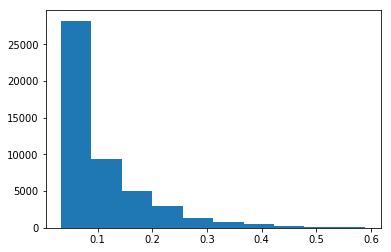

In [21]:
plt.hist( final_pred_lgb)
plt.show()

In [22]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_pred_lgb }).to_csv('../data/pred_lgb_oof-16.csv', index=False)

# Preds from downsample

(307511, 32)

In [23]:
preds_ds = new_test.mean( axis = 1 )
preds_ds.shape

(48744,)

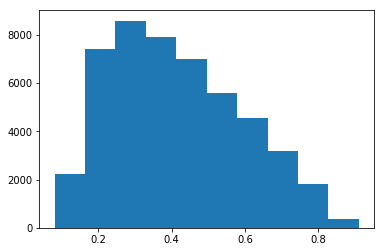

In [26]:
plt.hist(preds_ds) 
plt.show()

In [27]:
preds_ds = new_test.mean( axis = 1 )
preds_ds.shape

(48744,)

In [38]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds_ds }).to_csv('../data/pred_lgb_ds.csv', index=False)

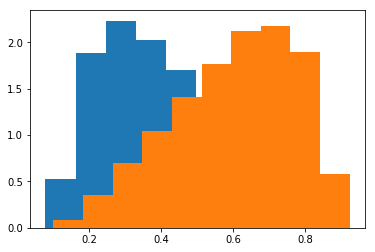

In [31]:
train_cv = new_train.mean( axis = 1 )

plt.hist( train_cv[ labels_train == 0 ], density = True )
plt.hist( train_cv[ labels_train == 1 ]  , density = True)
plt.show()

In [34]:
final_train = final_cv_train/M

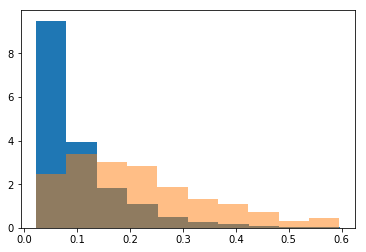

In [37]:
plt.hist( final_train[ labels_train == 0 ], density = True )
plt.hist( final_train[ labels_train == 1 ]  , density = True , alpha = 0.5 )
plt.show()

In [51]:
np.save( "./train_final" , new_train)

In [52]:
np.save( "./test_final" , new_test)

# XGboost model with oof_preds

In [53]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 5000
params = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [54]:
final_cv_train_xgbst = np.zeros(len(labels_train))
final_cv_pred_xgbst = np.zeros(len( test_ids ))

NFOLDS = 5 

M = 16
x_score_xgbst = []
dtest = xgb.DMatrix( new_test )
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]

        dtrain = xgb.DMatrix( X_train , label=label_train )
        dvalid = xgb.DMatrix( X_validate , label = label_validate )
        evallist = [ (dvalid, 'eval') ]
        bst = xgb.train(params, dtrain, num_boost_round, evallist  , early_stopping_rounds=100 , verbose_eval=100 )
        #bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        #cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
        
        cv_pred += bst.predict( dtest, ntree_limit=bst.best_ntree_limit )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( dvalid , ntree_limit=bst.best_ntree_limit )
    
    cv_pred /= NFOLDS
    
    final_cv_train_xgbst += cv_train
    final_cv_pred_xgbst += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train_xgbst / (s + 1.)), s+1)
    
    x_score_xgbst.append(roc_auc_score( labels_train , cv_train))

[0]	eval-auc:0.761492
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.785007
[200]	eval-auc:0.789916
[300]	eval-auc:0.791683
[400]	eval-auc:0.79293
[500]	eval-auc:0.793744
[600]	eval-auc:0.794055
[700]	eval-auc:0.794128
[800]	eval-auc:0.794168
[900]	eval-auc:0.794181
Stopping. Best iteration:
[894]	eval-auc:0.794181

[0]	eval-auc:0.766049
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.790358
[200]	eval-auc:0.794125
[300]	eval-auc:0.795585
[400]	eval-auc:0.796717
[500]	eval-auc:0.79733
[600]	eval-auc:0.797639
[700]	eval-auc:0.79771
[800]	eval-auc:0.797804
[900]	eval-auc:0.797833
[1000]	eval-auc:0.797823
Stopping. Best iteration:
[903]	eval-auc:0.797834

[0]	eval-auc:0.763781
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.787857
[200]	eval-auc:0.790989
[300]	eval-auc:0.792281
[400]	eval-auc:0.793487
[500]	eval-auc:0.794028
[600]	eval-auc:0.794416
[700]	eval-auc:0.794549
[800]	eval-auc:0.794638
[900]	eval-auc:

[800]	eval-auc:0.793634
[900]	eval-auc:0.793689
[1000]	eval-auc:0.793684
[1100]	eval-auc:0.793683
Stopping. Best iteration:
[1056]	eval-auc:0.793693

[0]	eval-auc:0.768978
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.795119
[200]	eval-auc:0.797536
[300]	eval-auc:0.799013
[400]	eval-auc:0.800473
[500]	eval-auc:0.801247
[600]	eval-auc:0.801539
[700]	eval-auc:0.801707
[800]	eval-auc:0.801879
[900]	eval-auc:0.801979
[1000]	eval-auc:0.802004
Stopping. Best iteration:
[965]	eval-auc:0.802022

cv score - on train:
0.7972164160179462
('current score in fold:', 0.7979220552085735, 4)
[0]	eval-auc:0.764539
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.789249
[200]	eval-auc:0.793001
[300]	eval-auc:0.794256
[400]	eval-auc:0.79536
[500]	eval-auc:0.79591
[600]	eval-auc:0.796245
[700]	eval-auc:0.796293
[800]	eval-auc:0.796353
[900]	eval-auc:0.796448
[1000]	eval-auc:0.79651
[1100]	eval-auc:0.796537
Stopping. Best iteration:
[1074]	eval-auc:0.796

[200]	eval-auc:0.788726
[300]	eval-auc:0.791255
[400]	eval-auc:0.792162
[500]	eval-auc:0.792735
[600]	eval-auc:0.793104
[700]	eval-auc:0.79318
[800]	eval-auc:0.793236
[900]	eval-auc:0.793356
[1000]	eval-auc:0.793409
[1100]	eval-auc:0.793491
[1200]	eval-auc:0.793558
[1300]	eval-auc:0.793598
[1400]	eval-auc:0.793623
Stopping. Best iteration:
[1393]	eval-auc:0.793627

[0]	eval-auc:0.768879
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.793267
[200]	eval-auc:0.79678
[300]	eval-auc:0.798269
[400]	eval-auc:0.799193
[500]	eval-auc:0.799564
[600]	eval-auc:0.799863
[700]	eval-auc:0.800073
[800]	eval-auc:0.800187
[900]	eval-auc:0.800308
[1000]	eval-auc:0.800362
[1100]	eval-auc:0.800407
[1200]	eval-auc:0.800443
[1300]	eval-auc:0.800462
[1400]	eval-auc:0.800482
[1500]	eval-auc:0.800489
Stopping. Best iteration:
[1459]	eval-auc:0.800493

[0]	eval-auc:0.771309
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.794678
[200]	eval-auc:0.798068
[300]	eva

[200]	eval-auc:0.793468
[300]	eval-auc:0.795133
[400]	eval-auc:0.796411
[500]	eval-auc:0.797099
[600]	eval-auc:0.797404
[700]	eval-auc:0.797521
[800]	eval-auc:0.797631
[900]	eval-auc:0.797751
[1000]	eval-auc:0.797802
[1100]	eval-auc:0.797836
[1200]	eval-auc:0.797853
[1300]	eval-auc:0.797888
[1400]	eval-auc:0.797892
Stopping. Best iteration:
[1323]	eval-auc:0.797898

[0]	eval-auc:0.764178
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.790565
[200]	eval-auc:0.793147
[300]	eval-auc:0.794468
[400]	eval-auc:0.795477
[500]	eval-auc:0.796157
[600]	eval-auc:0.796556
[700]	eval-auc:0.796655
[800]	eval-auc:0.796726
[900]	eval-auc:0.796775
[1000]	eval-auc:0.796819
[1100]	eval-auc:0.79685
[1200]	eval-auc:0.796825
Stopping. Best iteration:
[1101]	eval-auc:0.796851

[0]	eval-auc:0.766474
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.791178
[200]	eval-auc:0.794606
[300]	eval-auc:0.796115
[400]	eval-auc:0.79769
[500]	eval-auc:0.798361
[600]	eval-a

[100]	eval-auc:0.794211
[200]	eval-auc:0.798332
[300]	eval-auc:0.800179
[400]	eval-auc:0.801465
[500]	eval-auc:0.802145
[600]	eval-auc:0.802652
[700]	eval-auc:0.802795
[800]	eval-auc:0.802899
[900]	eval-auc:0.803001
[1000]	eval-auc:0.803113
[1100]	eval-auc:0.803203
[1200]	eval-auc:0.803247
[1300]	eval-auc:0.803259
Stopping. Best iteration:
[1260]	eval-auc:0.80327

[0]	eval-auc:0.76062
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.791466
[200]	eval-auc:0.794885
[300]	eval-auc:0.796638
[400]	eval-auc:0.797966
[500]	eval-auc:0.7987
[600]	eval-auc:0.798967
[700]	eval-auc:0.799068
[800]	eval-auc:0.799171
[900]	eval-auc:0.79926
[1000]	eval-auc:0.79928
[1100]	eval-auc:0.799287
[1200]	eval-auc:0.799297
Stopping. Best iteration:
[1176]	eval-auc:0.799316

[0]	eval-auc:0.763751
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.789048
[200]	eval-auc:0.792194
[300]	eval-auc:0.793527
[400]	eval-auc:0.794798
[500]	eval-auc:0.795322
[600]	eval-auc:0.

In [55]:
np.array( x_score_xgbst).mean()

0.797645903962534

In [58]:
final_xgb = final_cv_pred_xgbst/M

In [60]:
final_cv_pred_xgbst.shape

(48744,)

In [57]:
final_xgb

array([0.07650507, 0.13420207, 0.0377268 , ..., 0.01034438, 0.06920401,
       0.15846626])

In [27]:
final = final_cv_pred/32

In [28]:
final_train = final_cv_train_xgbst/32.0
final_train_lgb = final_cv_train/32.0

In [29]:
final_pos = final_train[ labels_train == 1  ]
final_neg = final_train[labels_train == 0 ]
final_pos_lgb = final_train_lgb[ labels_train == 1  ]
final_neg_lgb = final_train_lgb[labels_train == 0 ]

In [30]:
print( np.array( x_score).mean() )

0.7809469043300058


In [31]:
roc_auc_score( labels_train , final_cv_train/32 ) 

0.7979566678585848

In [32]:
a = len(final_pos)

In [33]:
b = len(final_neg)

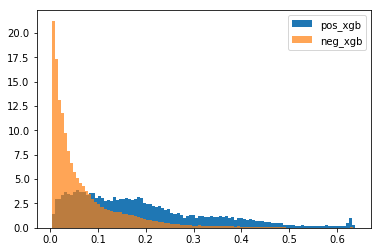

In [35]:
plt.hist( final_pos , density = True , bins = 100 , label = "pos_xgb" )
plt.hist(  final_neg  , density = True , bins = 100 , alpha = 0.7 , label = "neg_xgb")
#plt.hist( final_pos_lgb , density = True , bins = 100 , label = "pos_lgb" )
#plt.hist(  final_neg_lgb , density = True , bins = 100 , alpha = 0.7 , label = "neg_lgb")

plt.legend()
plt.show()

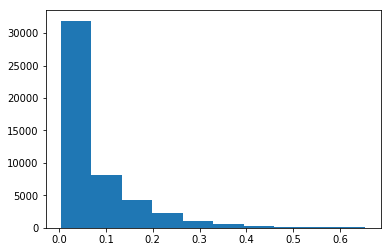

In [202]:
plt.hist( final_xgb)
plt.show()

In [111]:
final_logi.shape

(307511,)

In [203]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_pred_lgb }).to_csv('../data/pred_xgb_oof.csv', index=False)

# Rigde